In [7]:
!pip show torch
!pip show torchtext
!python --version

Name: torch
Version: 2.3.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: torchtext
Name: torchtext
Version: 0.18.0
Summary: Text utilities, models, transforms, and datasets for PyTorch.
Home-page: https://github.com/pytorch/text
Author: PyTorch Text Team
Author-email: packages@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/site-packages
Requires: numpy, requests, torch, tqdm
Required-by: 
Python 3.10.13


In [4]:
!pip uninstall torch
!pip install torch==2.3.0

Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/site-packages/functorch/*
    /usr/local/lib/python3.10/site-packages/torch-2.4.1.dist-info/*
    /usr/local/lib/python3.10/site-packages/torch/*
    /usr/local/lib/python3.10/site-packages/torchgen/*
    /usr/local/share/cmake/ATen/ATenConfig.cmake
    /usr/local/share/cmake/Caffe2/Caffe2Config.cmake
    /usr/local/share/cmake/Caffe2/Caffe2Targets-release.cmake
    /usr/local/share/cmake/Caffe2/Caffe2Targets.cmake
    /usr/local/share/cmake/Caffe2/FindCUDAToolkit.cmake
    /usr/local/share/cmake/Caffe2/FindCUSPARSELT.cmake
    /usr/local/share/cmake/Caffe2/FindSYCLToolkit.cmake
    /usr/local/share/cmake/Caffe2/Modules_CUDA_fix/FindCUDA.cmake
    /usr/local/share/cmake/Caffe2/Modules_CUDA_fix/FindCUDNN.cmake
    /usr/local/share/cmake/Caffe2/Modules_CUDA_fix/upstr

In [9]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0

  Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.8 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)


In [1]:
import torch
import torchtext
from torchtext import vocab
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [2]:
### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:26<00:00, 15382.12it/s]


In [3]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [13]:
#define the baseline model
class baselineModel(torch.nn.Module):
    def __init__(self, vocab, embedding_size=100):
        super().__init__()
        # convert word tokens into word vectors
        self.embeddings = nn.Embedding.from_pretrained(vocab.vectors)

        # prediction function takes aveaged embedding as input, and output a scalar
        self.linear = nn.Linear(embedding_size, 1)

    def forward(self, x):
        # Now shape transposed to (batch_size, length)
        x = x.transpose(0, 1)

        #(batch_size, length, embedding_dim)
        embedded = self.embeddings(x)

        # take average
        #(batch_size, embedding_dim)
        avg = torch.mean(embedded, dim=1)

        # linear layer
        # (batch_size, 1)
        output = self.linear(avg)

        #(batch_size)
        return output.reshape(-1)

In [30]:
# 4.4 Overfitting to debug
def overfit(epochs, batch_size):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    # 3.3.2
    overfit_dataset = TextDataset(glove, "overfit")
    val_dataset = TextDataset(glove, "validation")

    # 3.3.3
    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    model = baselineModel(glove)
    # BCEWithLogitsLoss combines both sigmoid and binary corss-entropy
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    total_trainloss = []
    train_accuracy = []
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for x_overfit,y_overfit in overfit_dataloader:
            optimizer.zero_grad()
            logits= model(x_overfit)
            loss = loss_function(logits, y_overfit.float())
            # backpropagate and update the weights
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predicted_labels = (torch.sigmoid(logits) > 0.5).float()
            correct += (predicted_labels == y_overfit).sum().item()
            total += y_overfit.size(0)

        # print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(overfit_dataloader)}')
        total_trainloss.append(epoch_loss/len(overfit_dataloader))
        # print(f'Epoch {epoch+1}, Train Accuracy: {correct/total}')
        train_accuracy.append(correct/total)

    # validation after training
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x_val, y_val in validation_dataloader:
            outputs = model(x_val)
            predicted_labels = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted_labels == y_val).sum().item()
            total += y_val.size(0)

    val_accracy = correct / total

    print(f"final train accuracy: {train_accuracy[-1]}")
    print(f"final validation accuracy: {val_accracy}")
    return total_trainloss, train_accuracy


Using device: cpu
final train accuracy: 1.0
final validation accuracy: 0.83875


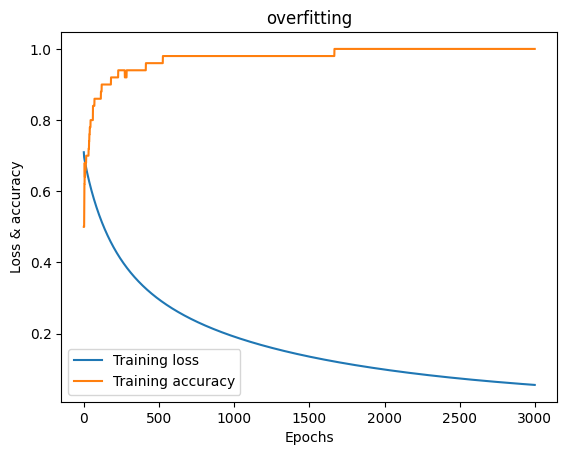

In [31]:
train_loss, train_acc= overfit(epochs=3000, batch_size=4)
plt.plot(train_loss, label = "Training loss")
plt.plot(train_acc, label = "Training accuracy")
plt.title("overfitting")
plt.xlabel("Epochs")
plt.ylabel("Loss & accuracy")
plt.legend()
plt.show()

In [14]:
def main(batch_size):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    # 3.3.2
    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    model = baselineModel(glove)
    # BCEWithLogitsLoss combines both sigmoid and binary corss-entropy
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    total_trainloss = []
    total_valloss = []
    total_testloss = []
    total_accuracy = []

    for epoch in range(50):
        epoch_loss = 0
        for x_train,y_train in train_dataloader:
            optimizer.zero_grad()
            logits= model(x_train)
            loss = loss_function(logits, y_train.float())
            # backpropagate and update the weights
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_dataloader)}')
        total_trainloss.append(epoch_loss/len(train_dataloader))

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val,y_val in validation_dataloader:
                logits= model(x_val)
                loss = loss_function(logits, y_val.float())

                val_loss += loss.item()
        print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(validation_dataloader)}')
        total_valloss.append(val_loss/len(validation_dataloader))

        # test and accuracy
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_test,y_test in test_dataloader:
                logits= model(x_test)
                loss = loss_function(logits, y_test.float())

                test_loss += loss.item()

                predicted_labels = (torch.sigmoid(logits) > 0.5).float()
                correct += (predicted_labels == y_test).sum().item()
                total += y_test.size(0)

        print(f'Epoch {epoch+1}, Test Loss: {test_loss/len(test_dataloader)}')
        total_testloss.append(test_loss/len(test_dataloader))
        print(f'Epoch {epoch+1}, Accuracy: {correct/total}')
        total_accuracy.append(correct/total)

    return model, total_trainloss, total_valloss, total_testloss,total_accuracy


Using device: cpu
Epoch 1, Train Loss: 0.6117230460979044
Epoch 1, Validation Loss: 0.5395252366364002
Epoch 1, Test Loss: 0.5386157351136207
Epoch 1, Accuracy: 0.7985
Epoch 2, Train Loss: 0.49940482461825014
Epoch 2, Validation Loss: 0.45773364942520856
Epoch 2, Test Loss: 0.456521036028862
Epoch 2, Accuracy: 0.8385
Epoch 3, Train Loss: 0.4418785998271778
Epoch 3, Validation Loss: 0.41172606060281397
Epoch 3, Test Loss: 0.4106490325033665
Epoch 3, Accuracy: 0.8565
Epoch 4, Train Loss: 0.40787540952675044
Epoch 4, Validation Loss: 0.3825980816408992
Epoch 4, Test Loss: 0.3817081649452448
Epoch 4, Accuracy: 0.865
Epoch 5, Train Loss: 0.38558459271211176
Epoch 5, Validation Loss: 0.36254682396538557
Epoch 5, Test Loss: 0.3617820015437901
Epoch 5, Accuracy: 0.8705
Epoch 6, Train Loss: 0.36982128468574954
Epoch 6, Validation Loss: 0.34787139828316865
Epoch 6, Test Loss: 0.3471480995900929
Epoch 6, Accuracy: 0.873
Epoch 7, Train Loss: 0.35802184479660354
Epoch 7, Validation Loss: 0.33663067

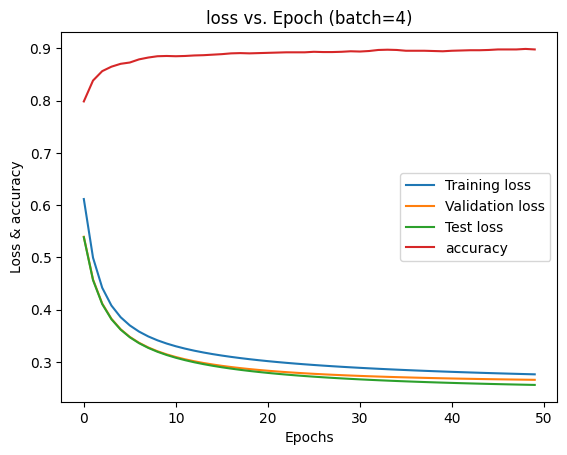

In [18]:
model_4, train_4, val_4, test_4, acc_4 = main(batch_size=4)
plt.plot(train_4, label = "Training loss")
plt.plot(val_4, label = "Validation loss")
plt.plot(test_4, label = "Test loss")
plt.plot(acc_4, label = "accuracy")
plt.title("loss vs. Epoch (batch=4)")
plt.xlabel("Epochs")
plt.ylabel("Loss & accuracy")
plt.legend()
plt.show()

In [32]:
#4.6
def print_closest_cosine_words(vec, n=5):
    cosine_dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0))
    cosine_lst = sorted(enumerate(cosine_dists.numpy()), key=lambda x: x[1], reverse=True) # sort by cosine similarity
    for idx, difference in cosine_lst[1:n+1]:                         # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)

In [34]:
print_closest_cosine_words(model_4.linear.weight[0].detach(), n=20)

insipid 	 0.53
pleasing 	 0.51
verbiage 	 0.51
emptier 	 0.50
underwhelming 	 0.50
campy 	 0.50
simplistic 	 0.50
funnily 	 0.50
watchable 	 0.49
appetizing 	 0.49
nuanced 	 0.49
laudatory 	 0.49
tepid 	 0.48
visuals 	 0.48
succinct 	 0.48
laughable 	 0.48
uninspired 	 0.47
crispness 	 0.47
glib 	 0.47
overacting 	 0.47


In [35]:
#4.7
torch.save(model_4.state_dict(), "/content/model_baseline.pt")